In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import sys
from torch.autograd import Variable
import torch.optim as optim
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
DIM = 10
class Net(nn.Module):
    def __init__(self, input_dim=DIM, out_dim=DIM):
        super(Net, self).__init__()
        self.h1 = nn.Linear(input_dim, 15)
        self.h2 = nn.Linear(15, 10)
        self.h3 = nn.Linear(10, 15)
        self.logit = nn.Linear(15, out_dim)

    def forward(self, x):
        x = torch.relu(self.h1(x))
        x = torch.relu(self.h2(x))
        x = torch.relu(self.h3(x))
        x = self.logit(x)
        return x
    
    def inner(self, x):
        x = torch.relu(self.h1(x))
        x = torch.relu(self.h2(x))
        return x

In [3]:
def fetch_batch(x, y, batch_index, batch_size):
    start = batch_index*batch_size
    end = batch_index*batch_size+batch_size
    x_batch = x[start:end]
    if y is not None:
        y_batch = y[start:end]
        return x_batch, y_batch
    else:
        return x_batch

In [4]:
def train(net, x_train, epoches=50, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    N_EPOCHES = epoches
    BS = 1000
    n_batches = int(np.ceil(x_train.shape[0] / BS))
    print(n_batches)
    train_losses = []
    for i in range(N_EPOCHES):
        y_train = x_train
        for bi in range(n_batches):
            x_batch, y_batch = fetch_batch(x_train, y_train, bi, BS)
            x_train_var = Variable(torch.from_numpy(x_batch))
            y_train_var = Variable(torch.from_numpy(y_batch))
            optimizer.zero_grad()
            outputs = net(x_train_var)
            loss = criterion(outputs, y_train_var)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            if bi%100 == 0:
                sys.stdout.write('\rEpoch: %d Iter: %d train loss: %.5f'
                                 %(i, bi, loss.item()))
                sys.stdout.flush()
    return train_losses

In [5]:
def gen_data(samples, dim, prop=0.95):
    x, y = make_classification(n_samples=samples,
                               n_features=dim,
                               n_redundant=0,
                               n_informative=dim,
                               n_clusters_per_class=1,
                               weights=[prop, 1-prop])
    return x, y

[0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0]


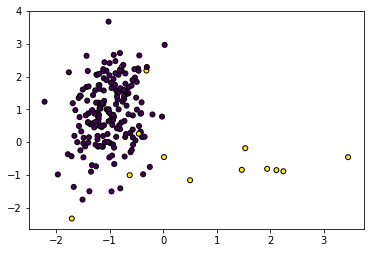

In [20]:
def test_gen_data():
    x, y = gen_data(200, 2)
    plt.scatter(x[:, 0], x[:, 1], marker='o', c=y,
                s=25, edgecolor='k')
    print(y)
    
test_gen_data()

15
Epoch: 49 Iter: 0 train loss: 0.05380

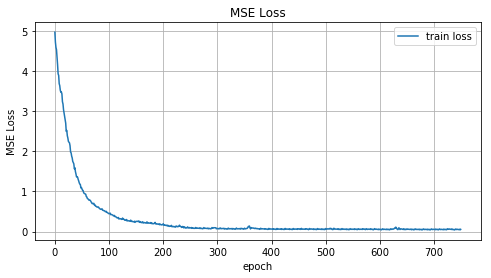

In [7]:
net = Net()
x, y = gen_data(30000, DIM, prop=0.99)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)
train_losses = train(net, x_train.astype(np.float32))
fig = plt.figure(figsize=(8, 4))
ax = sns.lineplot(np.arange(len(train_losses)), train_losses)
ax.set(xlabel='epoch', ylabel='MSE Loss')
plt.legend(['train loss'])
plt.title('MSE Loss')
plt.grid()
ax.set_axisbelow(True)
plt.show()

In [8]:
x_train_var = Variable(torch.from_numpy(x_test.astype(np.float32)[:1]))
y_train_var = Variable(torch.from_numpy(x_test.astype(np.float32)[:1]))
criterion = nn.MSELoss()
outputs = net(x_train_var)
loss = criterion(outputs, y_train_var)
loss

tensor(0.0552, grad_fn=<MseLossBackward>)

In [9]:
def simulate(data):
    errors = []
    for i, val in enumerate(data):
        x_train_var = Variable(torch.from_numpy(val.astype(np.float32)))
        y_train_var = Variable(torch.from_numpy(val.astype(np.float32)))
#       printint(val)
        criterion = nn.MSELoss()
        outputs = net(x_train_var)
        loss = criterion(outputs, y_train_var)
        errors.append(loss.detach().numpy())
    return errors

errors = simulate(x_test)

In [10]:
def plot_errors(errors, y_test):
    x = range(len(errors))
    y = errors
    for x, y, l in zip(x, y, y_test):
        if l == 0:
            plt.scatter(x, y, c='blue')
        else:
            plt.scatter(x, y, c='red')
    plt.show()

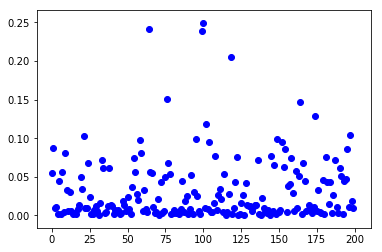

In [11]:
plot_errors(errors[:200], y_test[:200])

In [12]:
anom_errors = []
norm_errors = []
for err, label in zip(errors, y_test):
    if label == 0:
        norm_errors.append(err)
    else:
        anom_errors.append(err)

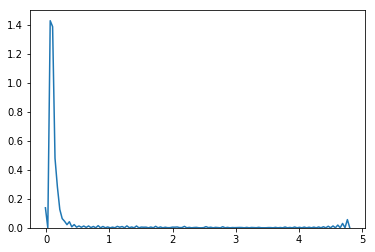

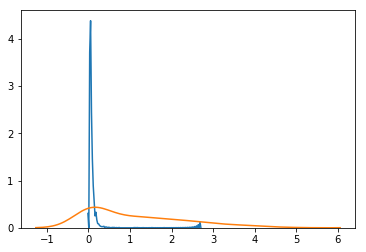

In [13]:
sns.distplot(errors, hist=False, norm_hist=False)
plt.show()
sns.distplot(norm_errors, hist=False, norm_hist=False)
# plt.show()
sns.distplot(anom_errors, hist=False, norm_hist=False)
plt.show()

In [14]:
errors_train = simulate(x_train)

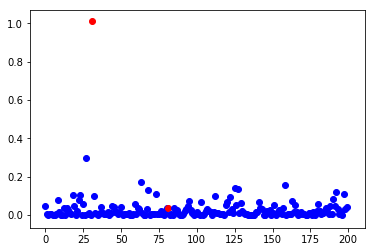

In [15]:
plot_errors(errors_train[100:300], y_train[100:300])

In [16]:
anom_errors_tr = []
norm_errors_tr = []
for err, label in zip(errors_train, y_train):
    if label == 0:
        norm_errors_tr.append(err)
    else:
        anom_errors_tr.append(err)

In [27]:
norm_errors_tr = np.array(norm_errors_tr)
print(norm_errors_tr[norm_errors_tr > 0.1].shape)
norm_errors_tr[norm_errors_tr < 0.1].shape

(941,)


(13818,)

In [28]:
anom_errors_tr = np.array(anom_errors_tr)
print(anom_errors_tr[anom_errors_tr > 0.1].shape)
anom_errors_tr[anom_errors_tr < 0.1].shape

(161,)


(80,)

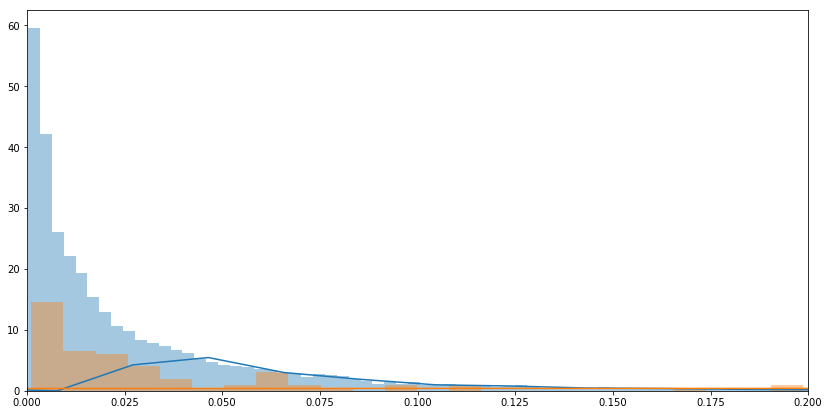

In [17]:
plt.subplots(figsize=(14, 7))
plt.xlim((0.0, 0.2))
sns.distplot(norm_errors_tr, bins=800)
sns.distplot(anom_errors_tr, bins=1000)
plt.show()

In [44]:
np.abs(np.log(anom_errors_tr[:10]))

array([1.7268583 , 0.87414974, 1.2973402 , 0.01108052, 3.3660138 ,
       0.9214843 , 1.115571  , 2.2248223 , 0.4403224 , 5.416552  ],
      dtype=float32)

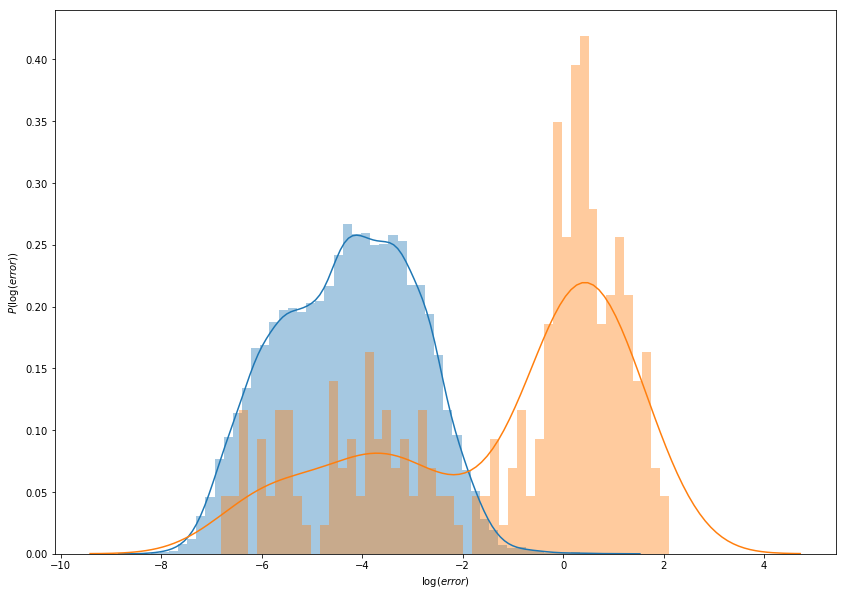

In [57]:
plt.subplots(figsize=(14, 10))
# plt.xlim((0.0, 0.2))
sns.distplot(np.log(norm_errors_tr), bins=50)
sns.distplot(np.log(anom_errors_tr), bins=50)
plt.xlabel('$\log (error)$')
plt.ylabel('$P(\log (error))$')
plt.show()

In [59]:
percentile = np.percentile(norm_errors_tr, 60)
print(percentile)
percentile_anom = np.percentile(anom_errors_tr, 60)
print(percentile_anom)

0.021509061753749843
1.199093222618103


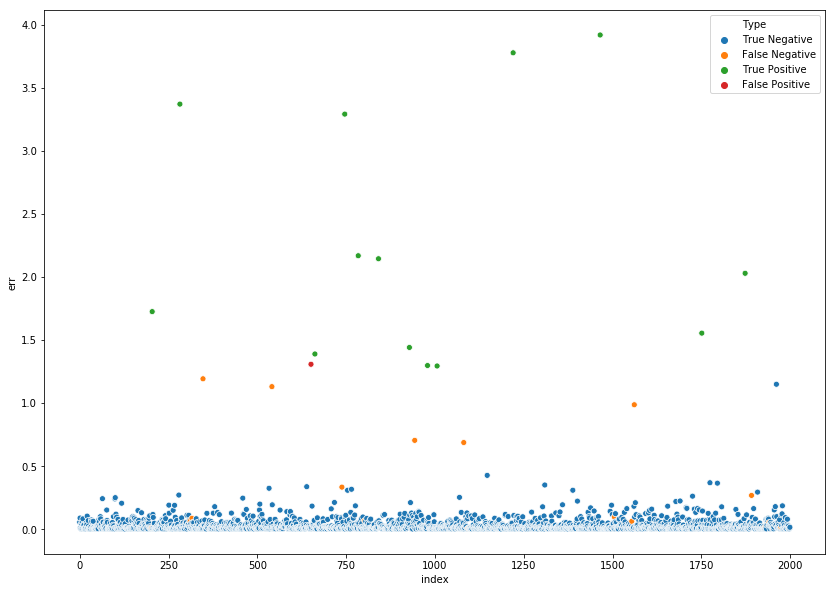

In [60]:
def plot_errors(errors, y_test, threshold):
#     x = range(len(errors))
#     y = errors
    plt.subplots(figsize=(14, 10))
    a = np.array([list(errors), list(y_test)]).transpose()
#     print(a.transpose())
#     print(a[:10].reshape((-1, 2)))
    df = pd.DataFrame(a.reshape((-1, 2)), columns=['err', 'label'])
    def add_color(x):
        l = x['label']
        y = x['err']
        if l == 0 and y < threshold:
            return 'True Negative'
        elif l == 0 and y > threshold:
            return 'False Positive'
        elif l == 1 and y > threshold:
            return 'True Positive'
        elif l == 1 and y < threshold:
            return 'False Negative'
    df["Type"] = df.apply(add_color, axis=1)
    df = df.reset_index()
#     display(df)
    sns.scatterplot(x='index', y='err', data=df, hue=df['Type'])
#     for c in ['green', 'yellow', 'red', 'orange']:
        
#     for x, y, l in zip(x, y, y_test):
#         if l == 0 and y < threshold:
#             plt.scatter(x, y, c='green')
#         elif l == 0 and y > threshold:
#             plt.scatter(x, y, c='yellow')
#         elif l == 1 and y > threshold:
#             plt.scatter(x, y, c='red')
#         elif l == 1 and y < threshold:
#             plt.scatter(x, y, c='orange')
    plt.show()

plot_errors(errors[:2000], y_test[:2000], percentile_anom)